# Introduction
## Question
How have the lyrics of the most popular songs in the US changed over time?
## Why Does It Matter?
From lullabies to birthday to dirges, music color and reflect our experiences. Music provides insight in the culture, norms, rituals, and values of a society. I am interested in observing the zeitgeist of the US through the years and how it changes. In relation to the data, I am interested in what popular music--specifically the number one single in Billboard's charts--can say about the people in the era and society.

Although the most popular song is decided by a wide variety of factors, one of the factors is the appeal to the general public, which is why I can gain insight to the time period through its  popular songs. It may bold assumption to make, but I think the lyrics of the songs every decade would be able to at least reflect, if not the zeitgeist,  some aspect of the culture at that decade.
# Sources
I am defining most popular song in the US as the #1 Billboard single in that decade. I’m getting the information of the #1 Billboard single from Wikipedia articles with links of the form “https://en.wikipedia.org/wiki/Billboard_year-end_top_30_singles_of_(year)”.

I’m using the Wikipedia articles as my source of information because I know Wikipedia allows web scraping. I've compared it with several other websites and the information matches up, so I think this is a trustworthy source.

I’m getting the lyrics by Googling the name of the songs and finding the first relevant results that don’t including [CHORUS] [VERSE 1] and the like. It’s much more manual but I haven’t found a less labor-intensive method of finding lyrics, especially for some of the older songs.

# Workflow
1. Collect songs from Wikipedia in the Jupyter notebook `Collecting Billboard Top 100 From Wikipedia`.
2. Import it into Google Sheets and manually populate the "Lyrics" column.
3. Export it as a .csv file and import it into this Jupyter notebook for data exploration.

# Assumptions & Concerns
I am using an equal number of songs from each decade to combat imbalances.
However, since I need to manually input the lyrics, the number of songs used is very few so I may end up drawing wrong conclusions based on unique characteristics of the specific songs I chose. Because of that, I'm making a huge assumption that my data is representative of the whole decade. However, I'm adding more lyrics to the list and re-running everything so I hope as I add more data, the assumption will become less of a stretch.
The underlying phenomena is the zeitgeist of each decade, and I am using the lyrics of the popular songs as a latent variable to investigate this.

Subsets:
1. 7 data points
    * #1 song in 1950, 1960, 1970, 1980, 1990, 2000, 2010
2. 14 data points
    * #1 song in 1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015
3. 28 data points
    * #1 & #2 songs in 1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015
4. 68 data points
    * #1 song from each year from 1950 to 2018
4. 136 data points
    * #1 & #2 songs from each year from 1950 to 2018
    
# Tools & Methods
## Preliminary Importing

In [1]:
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud

from collections import Counter
from string import punctuation

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use("seaborn-pastel")

# Data

In [2]:
#This is the saved csv file from Google Sheets with lyrics added to web-scrapped data
full_music = pd.read_csv("Billboard100(1950-2018).csv")
pd.to_numeric(full_music["Year"])
top30 = full_music.loc[full_music["Position"].isin([str(i) for i in np.arange(1, 30)])].reset_index(drop=True)
#Get the songs from the Billboard entries every 5 years
#subset_music = full_music.loc[full_music["Year"]%5 == 0]
subset_music = full_music
#Only get the #1 and #2 song in each Billboard entry
data = subset_music.loc[subset_music["Position"].isin(["1", "2"])].reset_index(drop=True)
print(data.shape)
data

(138, 5)


,Position,Song,Artist,Year,Lyrics
0,1,"""Goodnight Irene""",Gordon Jenkins & The Weavers,1950,"Irene, goodnight\nIrene, goodnight\nGoodnight,..."
1,2,"""Mona Lisa""",Nat King Cole,1950,"Mona lisa, mona lisa, men have named you\nyou'..."
2,1,"""Too Young""",Nat King Cole,1951,"Too young to go steady\nToo young, I hear her ..."
3,2,"""Because of You""",Tony Bennett,1951,Because of you there's a song in my heart\nBec...
4,1,"""Blue Tango""",Leroy Anderson,1952,Here am I with you in a world of blue\nAnd we'...
5,2,"""Wheel of Fortune""",Kay Starr,1952,The wheel of fortune\nGoes spinning around\nWi...
6,1,"""The Song from Moulin Rouge""",Percy Faith,1953,"When ever we kiss,\nI worry and wonder.\nYour ..."
7,2,"""Vaya con Dios""",Les Paul & Mary Ford,1953,"Now the hacienda's dark, the town is sleeping;..."
8,1,"""Little Things Mean a Lot""",Kitty Kallen,1954,Blow me a kiss from across the room\nSay I loo...
9,2,"""Wanted""",Perry Como,1954,"Wanted, someone who kissed me\nAnd held me clo..."


In [3]:
#Remove punctuation
data["Lyrics w/o Punctuation"] = [lyrics.lower().replace("\n"," ").translate(str.maketrans('', '', punctuation)) 
                                  for lyrics in data["Lyrics"]]
#Word tokenize
data["Lyrics by Words"] = [word_tokenize(lyrics) for lyrics in data["Lyrics w/o Punctuation"]]
#Create a decade column
data["Decade"] = [int(year/10) for year in data["Year"]]
music = data.groupby("Decade").agg(list)
music["Decade"] = [str(year[0])+"s" for year in music["Year"]]
#Create a table with the decade and the lyrics of the top 2 songs in XXX0 and XXX5
music = music.reset_index(drop=True)[["Decade", "Lyrics", "Lyrics w/o Punctuation", "Lyrics by Words"]]
music

,Decade,Lyrics,Lyrics w/o Punctuation,Lyrics by Words
0,1950s,"[Irene, goodnight\nIrene, goodnight\nGoodnight...",[irene goodnight irene goodnight goodnight ire...,"[[irene, goodnight, irene, goodnight, goodnigh..."
1,1960s,[There's a summer place\nWhere it may rain or ...,[theres a summer place where it may rain or st...,"[[theres, a, summer, place, where, it, may, ra..."
2,1970s,"[When you're weary, feeling small\nWhen tears ...",[when youre weary feeling small when tears are...,"[[when, youre, weary, feeling, small, when, te..."
3,1980s,"[Color me your color, baby\nColor me your car\...",[color me your color baby color me your car co...,"[[color, me, your, color, baby, color, me, you..."
4,1990s,[I know there's pain\nWhy do you lock yourself...,[i know theres pain why do you lock yourself u...,"[[i, know, theres, pain, why, do, you, lock, y..."
5,2000s,[I can feel the magic floating in the air\nBei...,[i can feel the magic floating in the air bein...,"[[i, can, feel, the, magic, floating, in, the,..."
6,2010s,[Wake up in the morning feeling like P Diddy (...,[wake up in the morning feeling like p diddy h...,"[[wake, up, in, the, morning, feeling, like, p..."


# Text Analysis
## Basic

In [4]:
top30["Decade"] = [int(year/10) for year in top30["Year"]]
artist_count = top30.groupby("Decade").agg(list)
#Count the number of unique artists in each decade (the rest have appeared on the list in the same decade)
artist_count["Unique Artists in Decade"] = [len(set(artists))/len(artists) for artists in artist_count["Artist"]]
all_artists = []
num_unique = []
for decade in artist_count["Artist"]:
    num_unique += [len(set([artist for artist in decade if artist not in all_artists]))/len(decade)]
    all_artists += decade
#Count the number of unique artists in each decade (the rest have appeared on the list in any of the previous decades)
artist_count["Unique Artists"] = num_unique
artist_count

,Position,Song,Artist,Year,Lyrics,Unique Artists in Decade,Unique Artists
Decade,,,,,,,
195,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[""Goodnight Irene"", ""Mona Lisa"", ""Third Man Th...","[Gordon Jenkins & The Weavers, Nat King Cole, ...","[1950, 1950, 1950, 1950, 1950, 1950, 1950, 195...","[Irene, goodnight\nIrene, goodnight\nGoodnight...",0.558621,0.558621
196,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[""Theme from A Summer Place"", ""He'll Have to G...","[Percy Faith, Jim Reeves, The Everly Brothers,...","[1960, 1960, 1960, 1960, 1960, 1960, 1960, 196...",[There's a summer place\nWhere it may rain or ...,0.768966,0.703448
197,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[""Bridge Over Troubled Water"", ""(They Long to ...","[Simon & Garfunkel, The Carpenters, The Guess ...","[1970, 1970, 1970, 1970, 1970, 1970, 1970, 197...","[When you're weary, feeling small\nWhen tears ...",0.741379,0.665517
198,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[""Call Me"", ""Another Brick in the Wall, Part I...","[Blondie, Pink Floyd, Olivia Newton-John, Mich...","[1980, 1980, 1980, 1980, 1980, 1980, 1980, 198...","[Color me your color, baby\nColor me your car\...",0.710345,0.627586
199,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[""Hold On"", ""It Must Have Been Love"", ""Nothing...","[Wilson Phillips, Roxette, Sinéad O'Connor, Be...","[1990, 1990, 1990, 1990, 1990, 1990, 1990, 199...",[I know there's pain\nWhy do you lock yourself...,0.693103,0.617241
200,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[""Breathe"", ""Smooth"", ""Maria Maria"", ""I Wanna ...","[Faith Hill, Santana featuring Rob Thomas, San...","[2000, 2000, 2000, 2000, 2000, 2000, 2000, 200...",[I can feel the magic floating in the air\nBei...,0.741379,0.672414
201,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[""Tik Tok"", ""Need You Now"", ""Hey, Soul Sister""...","[Kesha, Lady Antebellum, Train, Katy Perry fea...","[2010, 2010, 2010, 2010, 2010, 2010, 2010, 201...",[Wake up in the morning feeling like P Diddy (...,0.727969,0.666667


In [5]:
#Count all the times the artists appear.
all_artists_count = Counter(all_artists)
all_artists_df = pd.DataFrame(data={"Name":list(all_artists_count.keys()),
                                    "Count":list(all_artists_count.values())}).sort_values("Count", ascending=False)
all_artists_df.head()

,Name,Count
96,Elvis Presley,16
744,Mariah Carey,15
1026,Rihanna,11
19,Perry Como,11
652,Madonna,10


In [6]:
#Get average character count
music["Avg Character Count"] = [np.mean([len(lyrics.replace(" ","")) 
                                         for lyrics in decade])
                                for decade in music["Lyrics w/o Punctuation"]]
#Get average word count
music["Avg Word Count"] = [np.mean([len(lyrics) 
                                    for lyrics in decade]) 
                           for decade in music["Lyrics by Words"]]
music.head()

,Decade,Lyrics,Lyrics w/o Punctuation,Lyrics by Words,Avg Character Count,Avg Word Count
0,1950s,"[Irene, goodnight\nIrene, goodnight\nGoodnight...",[irene goodnight irene goodnight goodnight ire...,"[[irene, goodnight, irene, goodnight, goodnigh...",681.80,174.40
1,1960s,[There's a summer place\nWhere it may rain or ...,[theres a summer place where it may rain or st...,"[[theres, a, summer, place, where, it, may, ra...",704.05,187.10
2,1970s,"[When you're weary, feeling small\nWhen tears ...",[when youre weary feeling small when tears are...,"[[when, youre, weary, feeling, small, when, te...",951.75,252.45
3,1980s,"[Color me your color, baby\nColor me your car\...",[color me your color baby color me your car co...,"[[color, me, your, color, baby, color, me, you...",1048.25,280.50
4,1990s,[I know there's pain\nWhy do you lock yourself...,[i know theres pain why do you lock yourself u...,"[[i, know, theres, pain, why, do, you, lock, y...",1449.10,392.35


## Visualization

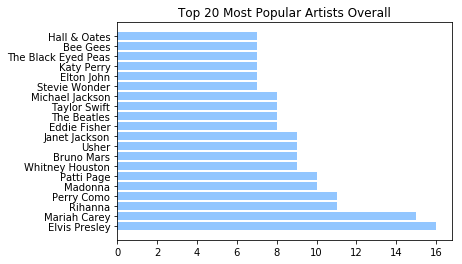

In [7]:
all_artists = Counter(all_artists_df)
plt.barh(all_artists_df["Name"][:20], all_artists_df["Count"][:20])
plt.title("Top 20 Most Popular Artists Overall");
#plt.savefig("popularbar.png");

Range: 16 to 1


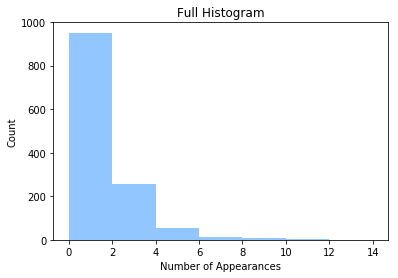

In [8]:
counts = list(all_artists_df["Count"])
print("Range:", str(counts[0]), "to", str(counts[-1]))
plt.hist(all_artists_df["Count"], bins=np.arange(0, 16, 2))
plt.xlabel("Number of Appearances")
plt.ylabel("Count")
plt.title("Full Histogram")
plt.show();

### Number of Characters

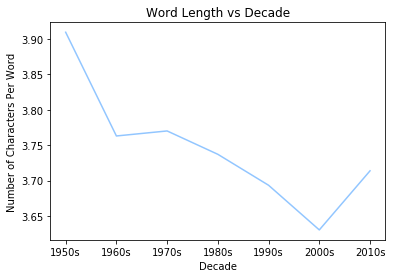

In [9]:
plt.plot(music["Decade"], music["Avg Character Count"]/music["Avg Word Count"])
plt.ylabel("Number of Characters Per Word")
plt.xlabel("Decade")
plt.title("Word Length vs Decade");
#plt.savefig("wordlenvsdecade.tiff");

### Number of Words

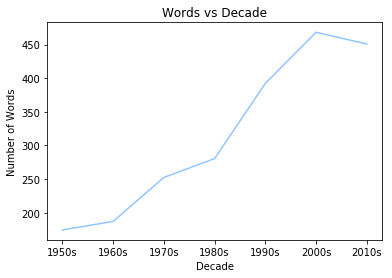

In [10]:
plt.plot(music["Decade"], music["Avg Word Count"])
plt.ylabel("Number of Words")
plt.xlabel("Decade")
plt.title("Words vs Decade");
#plt.savefig("wordsvsdecade.tiff");

## Frequency Analysis

In [11]:
decade_pov_single_1 = []
decade_pov_plural_1 = []
decade_pov_2 = []
decade_male = []
decade_female = []
decade_pov_inc = []
decade_pov_ego = []
first_person_single = ["i", "me", "my", "myself", "mine"]
first_person_plural = ["we", "us", "our", "ours"]
second_person = ["you", "your", "yours", "yourself", "yourselves"]
male = ["he", "his", "him"]
female = ["she", "her", "hers"]
for decade in music["Lyrics by Words"]:
    
    songs_pov_single_1 = []
    songs_pov_plural_1 = []
    songs_pov_2 = []
    songs_male = []
    songs_female = []
    
    for song in decade:
        
        words_first_single = 0
        words_first_plural = 0
        words_second = 0
        words_male = 0
        words_female = 0
        
        for word in song:
            
            #Count number of words in first person singular
            if word in first_person_single:
                words_first_single += 1
                
            #Count number of words in first person plural
            if word in first_person_plural:
                words_first_plural += 1
                
            #Count number of words in second person
            if word in second_person:
                words_second += 1
                
            #Count number of male pronouns
            if word in male:
                words_male += 1
                
            #Count number of female pronouns
            if word in female:
                words_female += 1
                
        #Put it in terms of the whole song
        song_len = len(song)
        songs_pov_single_1 += [words_first_single/song_len]
        songs_pov_plural_1 += [words_first_plural/song_len]
        songs_pov_2 += [words_second/song_len]
        songs_male += [words_male/song_len]
        songs_female += [words_female/song_len]
        
    songs_pov_single_1 = np.mean(songs_pov_single_1)
    songs_pov_plural_1 = np.mean(songs_pov_plural_1)
    songs_pov_2 = np.mean(songs_pov_2)
    songs_male = np.mean(songs_male)
    songs_female = np.mean(songs_female)
    
    #Find the mean in each decade
    decade_pov_single_1 += [songs_pov_single_1]
    decade_pov_plural_1 += [songs_pov_plural_1]
    decade_pov_2 += [songs_pov_2]
    decade_male += [songs_male]
    decade_female += [songs_female]
    decade_pov_inc += [songs_pov_plural_1 + songs_pov_2]
    decade_pov_ego += [songs_pov_single_1 + songs_pov_plural_1]

In [12]:
def pos_counter(pos_tag):
    
    pos = []
    freq = []
    
    for _, tag in pos_tag:
        
        if tag not in pos:
            pos += [tag]
            freq += [1]
        else:
            freq[pos.index(tag)] += 1
            
    freq = freq/np.sum(freq)
    return pos, freq

In [13]:
decade_pos_tag = []
decade_pos = {}

for i in np.arange(len(music["Lyrics by Words"])):
    
    decade = music["Lyrics by Words"][i]
    decade_pos_tag += [[]]
    decade_dict = {}
    
    #Populate the dictionary of the decade with the POS frequencies for each song
    for j in np.arange(len(decade)):
        
        song = decade[j]
        decade_pos_tag[i] += [pos_tag(song)]
        pos = pos_counter(decade_pos_tag[i][j])
        label = pos[0]
        freq = pos[1]
        
        for label, freq in zip(label, freq):
            
            if label in decade_pos:
                decade_dict[label] += [freq]
            else:
                decade_dict[label] = [freq]
                
    #Combine each song's frequencies into a mean
    for item in decade_dict:
        decade_dict[item] = np.mean(decade_dict[item])
        
    #Add it to the decade_pos dictionary
    decade_pos[music["Decade"][i]] = decade_dict

In [14]:
#WDT: wh-determiner, which
#WP: wh-pronoun, who, what
#WP$: possessive wh-pronoun, whose
#WRB: wh-abverb, where, when
decade_spec = []

#PRP: personal pronoun, I, he, she
decade_prp = []

#PRP$: possessive pronoun, my, his, hers
decade_prps = []

#PRP + PRP$
decade_prgen = []

for decade in decade_pos:
    
    pos = decade_pos[decade]
    
    prp = 0
    if "PRP" in pos:
        prp = pos["PRP"]
    decade_prp += [prp]  
    
    prps = 0
    if "PRP$" in pos:
        prps = pos["PRP$"]
    decade_prps += [prps] 
    
    decade_prgen += [prp + prps]
    
    spec = 0
    if "WDT" in pos:
        spec += pos["WDT"]
    if "WP" in pos:
        spec += pos["WP"]
    if "WP$" in pos:
        spec += pos["WP$"]
    if "WRB" in pos:
        spec += pos["WRB"]
    decade_spec += [spec]

In [15]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith("J"):
        return wordnet.ADJ
    elif treebank_tag.startswith("V"):
        return wordnet.VERB
    elif treebank_tag.startswith("N"):
        return wordnet.NOUN
    elif treebank_tag.startswith("R"):
        return wordnet.ADV
    else:
        return None

In [16]:
def lemmatize(word, tag):
    
    tag = get_wordnet_pos(tag)
    
    if tag:
        return lemmatizer.lemmatize(word, tag)
    else:
        return lemmatizer.lemmatize(word)

In [17]:
stop_words = set(stopwords.words('english')) 
lemmatizer = WordNetLemmatizer()

unique_lyrics = []
unique_lyrics_no_stopwords = []

for i in np.arange(len(music)):
    
    decade = decade_pos_tag[i]
    unique_lyrics += [[]]
    unique_lyrics_no_stopwords += [[]]
    
    for j in np.arange(len(decade)):
        
        song = decade[j]
        
        #lemmatize words. I removed punctuations so i'll -> ill != i != ive
        unique_lyrics[i] += [set([lemmatize(word, tag) for (word, tag) in song])]
        
    #remove stopwords from unique_lyrics' entry.
    unique_lyrics_no_stopwords[i] += [[w for w in song if not w in stop_words] for song in unique_lyrics[i]] 

In [18]:
#find the average number of unique words (with and without stopwords)
len_unique = []
len_unique_no_stop = []

for i in np.arange(len(music)):
    
    decade = unique_lyrics[i]
    decade_no_stop = unique_lyrics_no_stopwords[i]
    
    unique = []
    unique_no_stop = []
    for j in np.arange(len(decade)):
        
        unique += [len(decade[j])]
        unique_no_stop += [len(decade_no_stop[j])]
    
    len_unique += [np.mean(unique)]
    len_unique_no_stop += [np.mean(unique_no_stop)]
len_unique_percent = len_unique/music["Avg Word Count"]
len_unique_no_stop_percent = len_unique_no_stop/music["Avg Word Count"]

## Visualization
### Parts of Speech

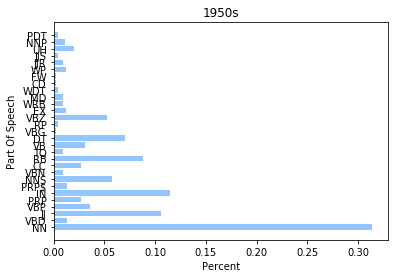

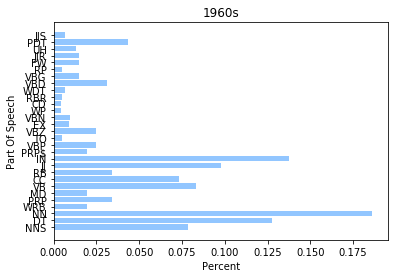

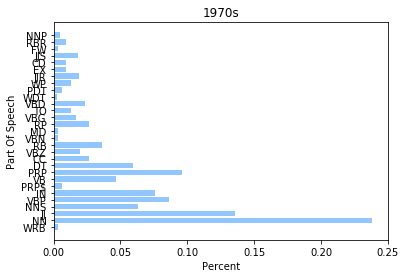

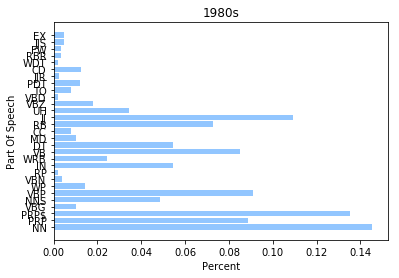

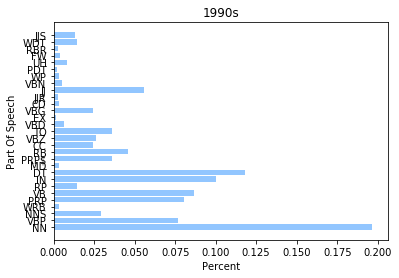

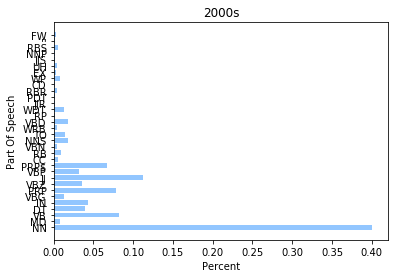

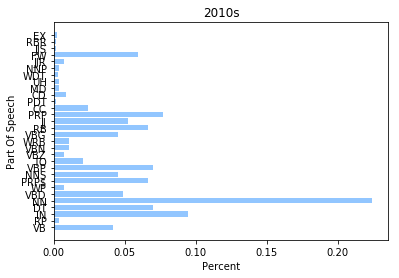

In [19]:
for decade in decade_pos:
    plt.title(decade)
    plt.barh(list(decade_pos[decade].keys()), list(decade_pos[decade].values()))
    plt.ylabel("Part Of Speech")
    plt.xlabel("Percent")
    plt.show();
    #plt.savefig(decade+"pos.tiff");

### Speculative Words

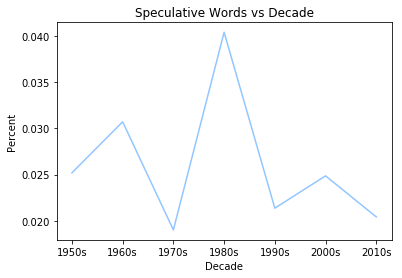

In [20]:
plt.plot(music["Decade"], decade_spec)
plt.ylabel("Percent")
plt.xlabel("Decade")
plt.title("Speculative Words vs Decade");
#plt.savefig("specvsdecade.tiff");

### Personal Pronouns

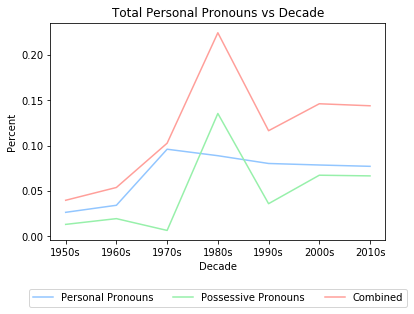

In [21]:
plt.plot(music["Decade"], decade_prp, label="Personal Pronouns")
plt.plot(music["Decade"], decade_prps, label="Possessive Pronouns")
plt.plot(music["Decade"], decade_prgen, label="Combined")
plt.ylabel("Percent")
plt.xlabel("Decade")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.title("Total Personal Pronouns vs Decade");
#plt.savefig("prpvsdecade.tiff");

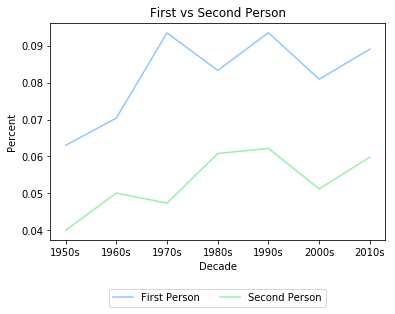

In [22]:
plt.plot(music["Decade"], decade_pov_ego, label="First Person")
plt.plot(music["Decade"], decade_pov_2, label="Second Person")
plt.ylabel("Percent")
plt.xlabel("Decade")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.title("First vs Second Person");
#plt.savefig("firstvssecond.tiff");

### Intimacy

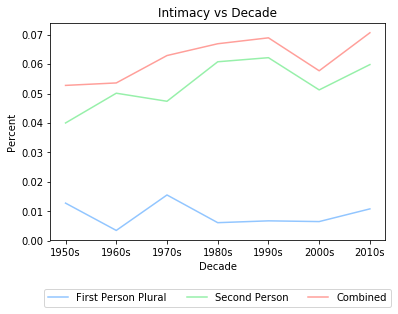

In [23]:
plt.plot(music["Decade"], decade_pov_plural_1, label="First Person Plural")
plt.plot(music["Decade"], decade_pov_2, label="Second Person")
plt.plot(music["Decade"], decade_pov_inc, label="Combined")
plt.ylabel("Percent")
plt.xlabel("Decade")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.title("Intimacy vs Decade");
#plt.savefig("intimvsdecade.tiff");

### Egocentricity

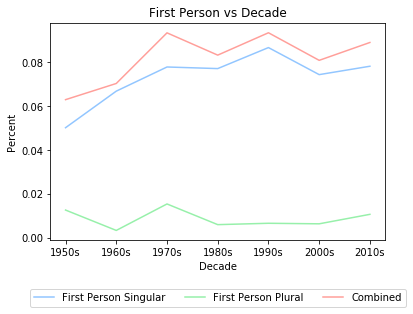

In [24]:
plt.plot(music["Decade"], decade_pov_single_1, label="First Person Singular")
plt.plot(music["Decade"], decade_pov_plural_1, label="First Person Plural")
plt.plot(music["Decade"], decade_pov_ego, label="Combined")
plt.ylabel("Percent")
plt.xlabel("Decade")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.title("First Person vs Decade");
#plt.savefig("firstvsdecade.tiff");

### Gendered Pronouns

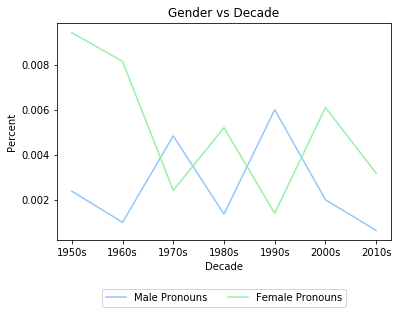

In [25]:
plt.plot(music["Decade"], decade_male, label="Male Pronouns")
plt.plot(music["Decade"], decade_female, label="Female Pronouns")
plt.ylabel("Percent")
plt.xlabel("Decade")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.title("Gender vs Decade");
#plt.savefig("gendervsdecade.tiff");

### Uniqueness (Lexical Diversity)

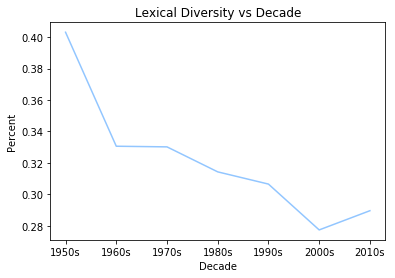

In [26]:
plt.plot(music["Decade"], len_unique_percent)
plt.ylabel("Percent")
plt.xlabel("Decade")
plt.title("Lexical Diversity vs Decade");
#plt.savefig("uniquestopvsdecade.tiff");

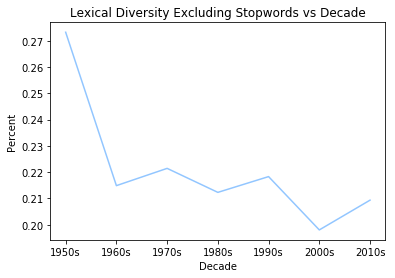

In [27]:
plt.plot(music["Decade"], len_unique_no_stop_percent)
plt.ylabel("Percent")
plt.xlabel("Decade")
plt.title("Lexical Diversity Excluding Stopwords vs Decade");
#plt.savefig("uniquenostopcountvsdecade.tiff");

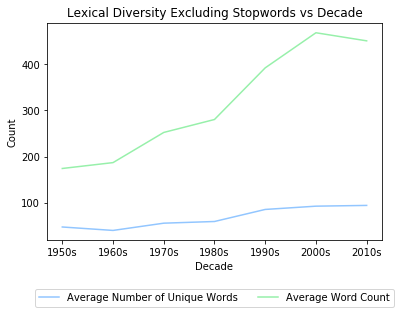

In [28]:
plt.plot(music["Decade"], len_unique_no_stop, label="Average Number of Unique Words")
plt.plot(music["Decade"], music["Avg Word Count"], label="Average Word Count")
plt.ylabel("Count")
plt.xlabel("Decade")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.title("Lexical Diversity Excluding Stopwords vs Decade");
#plt.savefig("uniquenostopcountvsdecade.tiff");

## Network Graph

In [29]:
#List of all nodes
all_nodes = []

decades = music["Decade"]
#Removes duplicate years
years = set(data["Year"])
songs = data["Song"]
#Removes quotes around song titles
songs = [song.replace("\"", "") for song in songs]
unique_words_no_stop = unique_lyrics_no_stopwords

all_nodes.extend(decades)
all_nodes.extend(years)
all_nodes.extend(songs)
for decade in unique_words_no_stop:
    for song in decade:
        all_nodes.extend(song)
        
node_type = []
node_type += ["Decade"] * len(decades)
node_type += ["Year"] * len(years)
node_type += ["Song"] * len(songs)
node_type += ["Words"] * (len(all_nodes) - len(node_type))

type_corr = {"Decade":4, "Year":3, "Song":2, "Words":1}
int_type = [type_corr.get(num) for num in node_type]

all_nodes = pd.DataFrame(data={"Id":all_nodes, "Label":all_nodes, "Type":node_type, "Int Type":int_type})
print(all_nodes.shape)
all_nodes.head()

(9547, 4)


,Id,Label,Type,Int Type
0,1950s,1950s,Decade,4
1,1960s,1960s,Decade,4
2,1970s,1970s,Decade,4
3,1980s,1980s,Decade,4
4,1990s,1990s,Decade,4


In [40]:
#List of all edges
src = []
tgt = []

#Edges from years to the decade
points_in_decade = sum(data["Year"].isin(np.arange(data["Year"][0], data["Year"][0] + 10)))
start = 0
for year in decades:
    if start + points_in_decade > len(data["Year"]):
        points_in_decade = len(src) - start
    src += list(data["Year"][start:start + points_in_decade])
    tgt += [year] * points_in_decade
    start += points_in_decade

#Edges from songs to years
src += songs
tgt += list(data["Year"])

#Edges from unique words to song
song_ind = 0
for i in np.arange(len(music)):
    
    decade_lyrics = unique_lyrics_no_stopwords[i]
    
    for j in np.arange(len(decade_lyrics)):
        lyrics = decade_lyrics[j]
        src += lyrics
        tgt += [songs[song_ind]] * len(lyrics)
        song_ind += 1

all_edges = pd.DataFrame(data={"Id":np.arange(len(src)), "Source":src, "Target":tgt})
print(all_edges.shape)
all_edges.head()

(9591, 3)


,Id,Source,Target
0,0,1950,1950s
1,1,1950,1950s
2,2,1951,1950s
3,3,1951,1950s
4,4,1952,1950s


In [41]:
all_nodes.to_csv("lyric_nodes.csv",index=False)
all_edges.to_csv("lyric_edges.csv",index=False)

## Visualization
### Gephi
# <span style="color:blue">WORK IN PROGRESS</span>
## Sentiment Analysis

In [42]:
sid = SentimentIntensityAnalyzer()

#total counts the total number of phrases in positive, neutral, and negative
sentiments = ["positive", "neutral", "negative"]
sentiment_summary = {"positive":[], "neutral":[], "negative":[], "total":[]}

#Analyze each phrase (line) and categorize the sentiment.
for i in np.arange(len(music)):
    
    decade = music["Lyrics"][i]
    
    for key in sentiment_summary.keys():
        
        sentiment_summary[key] += [0]
        
    for j in np.arange(len(decade)):
        
        song = decade[j].split("\n")
        
        for phrase in song:
            
            sentiment_score = sid.polarity_scores(phrase)
            
            sentiment_summary["total"][i] += 1
            
            if sentiment_score["compound"] == 0.0:
                sentiment_summary["neutral"][i] += 1
            elif sentiment_score["compound"] > 0.0:
                sentiment_summary["positive"][i] += 1
            else:
                sentiment_summary["negative"][i] += 1

sentiment_summary["neutral"] = [sent/total for sent, total 
                                in zip(sentiment_summary["neutral"],
                                       sentiment_summary["total"])]
sentiment_summary["positive"] = [sent/total for sent, total 
                                in zip(sentiment_summary["positive"],
                                       sentiment_summary["total"])]
sentiment_summary["negative"] = [sent/total for sent, total 
                                in zip(sentiment_summary["negative"],
                                       sentiment_summary["total"])]
                
print(sentiment_summary)

{'positive': [0.3240223463687151, 0.28762541806020064, 0.27320261437908494, 0.26393629124004553, 0.25516693163751986, 0.23166926677067082, 0.343205574912892], 'neutral': [0.5083798882681564, 0.5752508361204013, 0.5869281045751634, 0.5779294653014789, 0.5866454689984102, 0.5811232449297972, 0.5043554006968641], 'negative': [0.16759776536312848, 0.13712374581939799, 0.13986928104575164, 0.15813424345847554, 0.15818759936406995, 0.187207488299532, 0.1524390243902439], 'total': [537, 598, 765, 879, 1258, 1282, 1148]}


## Visualization

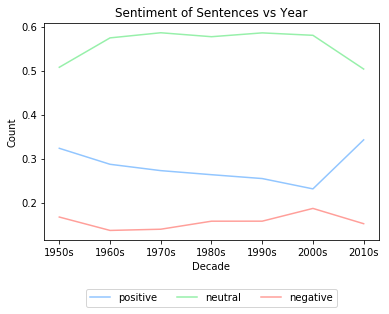

In [43]:
for sentiment in sentiments:
    plt.plot(music["Decade"], sentiment_summary[sentiment], label=sentiment)
plt.ylabel("Count")
plt.xlabel("Decade")
plt.title("Sentiment of Sentences vs Year");
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3);
#plt.savefig("sentvsyear.tiff");

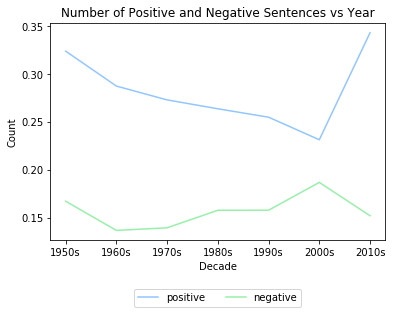

In [44]:
plt.plot(music["Decade"], sentiment_summary[sentiments[0]], label=sentiments[0])
plt.plot(music["Decade"], sentiment_summary[sentiments[2]], label=sentiments[2])
plt.ylabel("Count")
plt.xlabel("Decade")
plt.title("Number of Positive and Negative Sentences vs Year");
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3);
#plt.savefig("posnegvsyear.tiff");

## Common Words

In [45]:
#Creating lyrics lists

#By decade
lyrics_by_decade_list = []

#Overall
lyrics_freq_list = []

for i in np.arange(len(music)):
    
    decade = decade_pos_tag[i]
    lyrics_by_decade_list += [[]]
    
    for j in np.arange(len(decade)):
        
        song = decade[j]
        
        #Removing stopwords
        lyrics = [lemmatize(word, tag) for (word, tag) in song]
        lyrics = [w for w in lyrics if not w in stop_words]
        
        lyrics_by_decade_list[i] += lyrics
        lyrics_freq_list += lyrics


#Converting lyrics lists to counters
#By decade
lyrics_by_decade = [Counter(lyrics) for lyrics in lyrics_by_decade_list]

#Overall
lyrics_freq = Counter(lyrics_freq_list)

In [46]:
decade_lyric_freqs = [pd.DataFrame(data={"Word":list(decade.keys()),
                                         "Count":list(decade.values())})
                      .sort_values("Count", ascending=False)
                      for decade in lyrics_by_decade]
decade_lyric_freqs[0].head()

,Word,Count
4,dream,36
306,rock,34
107,love,32
161,im,25
48,lonely,25


In [47]:
overall_lyric_freq = pd.DataFrame(data={"Word":list(lyrics_freq.keys()),
                                        "Count":list(lyrics_freq.values())})
overall_lyric_freq = overall_lyric_freq.sort_values("Count", ascending=False)
overall_lyric_freq.head()

,Word,Count
8,get,488
161,im,417
107,love,396
135,know,375
128,dont,307


In [48]:
vectorizer = TfidfVectorizer()

decade_lyrics = []

for i in np.arange(len(music["Lyrics w/o Punctuation"])):
    decade_lyrics += [" ".join(music["Lyrics w/o Punctuation"][i])]

tfidf = vectorizer.fit_transform(decade_lyrics)
tfidf = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names())

common = []

for i in np.arange(len(music)):
    print("Most common words of", music["Decade"][i], "are:")
    common += [tfidf.iloc[i].sort_values(ascending=False)]
    print(tfidf.iloc[i].sort_values(ascending=False).head(), "\n")

Most common words of 1950s are:
the    0.404598
and    0.271943
you    0.268627
to     0.242096
be     0.169135
Name: 0, dtype: float64 

Most common words of 1960s are:
na      0.520794
you     0.325092
the     0.263711
jude    0.254972
and     0.238704
Name: 1, dtype: float64 

Most common words of 1970s are:
the    0.475080
you    0.365912
to     0.317394
and    0.287069
me     0.216313
Name: 2, dtype: float64 

Most common words of 1980s are:
you    0.467967
the    0.385933
me     0.296441
my     0.244238
to     0.229322
Name: 3, dtype: float64 

Most common words of 1990s are:
you    0.505600
the    0.339375
to     0.264574
it     0.252107
and    0.235485
Name: 4, dtype: float64 

Most common words of 2000s are:
you     0.452697
the     0.410011
boom    0.242536
to      0.211184
me      0.211184
Name: 5, dtype: float64 

Most common words of 2010s are:
you    0.484025
the    0.249007
and    0.240614
me     0.233619
my     0.195848
Name: 6, dtype: float64 



## Visualization
### Top 10 most Frequent Words
#### By Decade

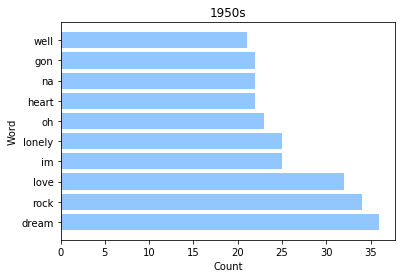

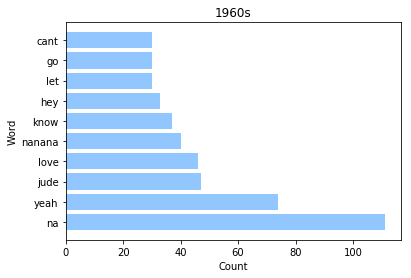

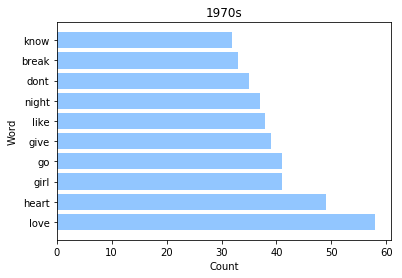

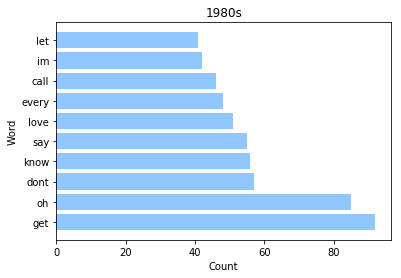

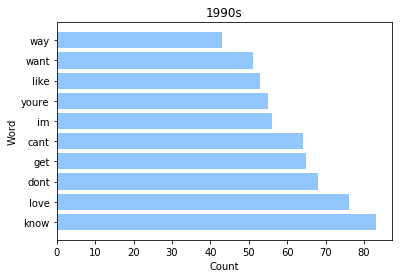

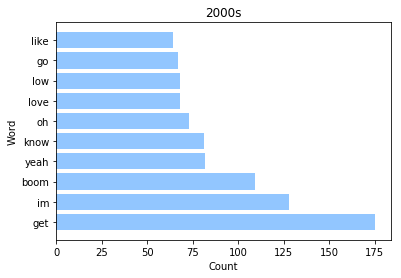

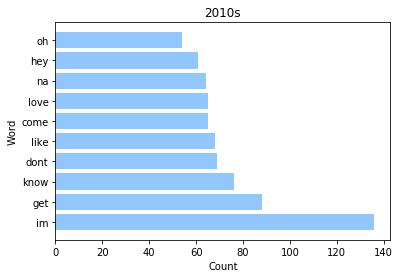

In [79]:
titles = music["Decade"]
i = 0
words_10 = []
for decade in decade_lyric_freqs:
    words_10.extend(list(decade["Word"]))
    plt.barh(decade["Word"][:10], decade["Count"][:10])
    plt.title(titles[i])
    plt.ylabel("Word")
    plt.xlabel("Count")
    plt.show();
    #plt.savefig(titles[i]+"wordbar.png");
    i += 1
words_10 = Counter(words_10)

In [83]:
#max is 7
words_10_duplicates = [i for i in words_10.elements() if words_10[i] > 6]
print(Counter(words_10_duplicates))

Counter({'love': 7, 'im': 7, 'oh': 7, 'heart': 7, 'na': 7, 'gon': 7, 'well': 7, 'say': 7, 'ill': 7, 'want': 7, 'dont': 7, 'like': 7, 'baby': 7, 'could': 7, 'day': 7, 'give': 7, 'know': 7, 'see': 7, 'someone': 7, 'go': 7, 'always': 7, 'thats': 7, 'way': 7, 'take': 7, 'make': 7, 'get': 7, 'look': 7, 'youre': 7, 'please': 7, 'night': 7, 'never': 7, 'find': 7, 'let': 7, 'away': 7, 'turn': 7, 'come': 7, 'thing': 7, 'life': 7, 'break': 7, 'hold': 7, 'one': 7, 'back': 7, 'cry': 7, 'hand': 7, 'youll': 7, 'wait': 7, 'long': 7, 'think': 7, 'time': 7, 'stop': 7, 'two': 7, 'start': 7, 'mine': 7, 'touch': 7, 'live': 7, 'yeah': 7, 'nothing': 7, 'last': 7, 'line': 7, 'right': 7, 'lose': 7, 'need': 7, 'tell': 7, 'feel': 7, 'hear': 7, 'eye': 7, 'id': 7, 'every': 7, 'girl': 7, 'walk': 7, 'cant': 7, 'leave': 7, 'still': 7, 'mind': 7, 'stand': 7, 'share': 7, 'cause': 7, 'ive': 7, 'home': 7, 'ooh': 7, 'another': 7, 'call': 7, 'much': 7, 'name': 7, 'play': 7, 'dance': 7, 'star': 7, 'inside': 7, 'try': 7, 'a

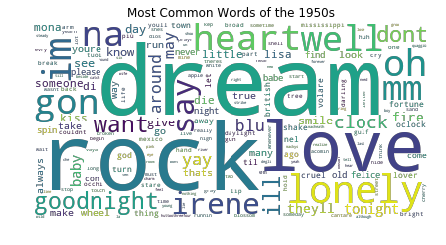

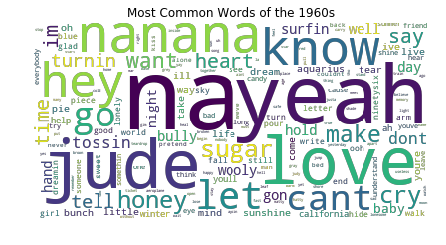

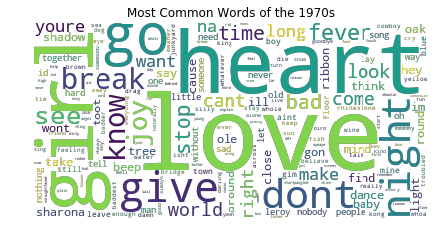

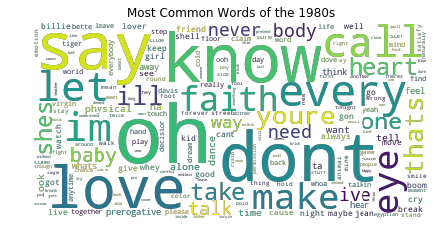

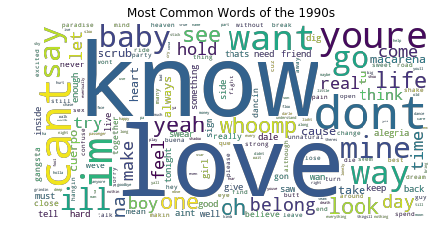

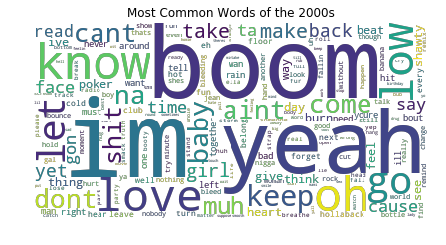

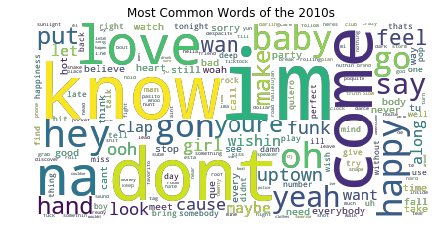

In [50]:
titles = music["Decade"]
i = 0

for decade in lyrics_by_decade_list:
    decade = " ".join(decade)
    wordcloud = WordCloud(mode="RGBA", background_color=None, collocations=False).generate(decade)
    fig = plt.figure()
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.title("Most Common Words of the " + titles[i])
    plt.show();
    #wordcloud.to_file(titles[i]+"words.png")
    i += 1

#### Overall

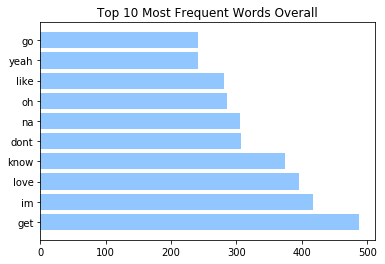

In [51]:
plt.barh(overall_lyric_freq["Word"][:10], overall_lyric_freq["Count"][:10])
plt.title("Top 10 Most Frequent Words Overall");
#plt.savefig("overallwordbar.png");

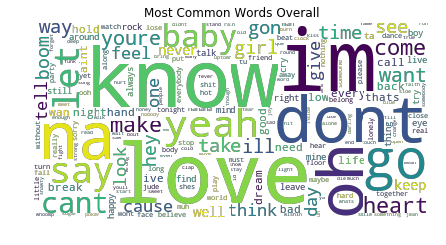

In [52]:
overall = " ".join(lyrics_freq_list)
wordcloud = WordCloud(mode="RGBA", background_color=None, collocations=False).generate(overall)
fig = plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title("Most Common Words Overall")
plt.show();
#wordcloud.to_file("overallwords.png")

### TF-IDF

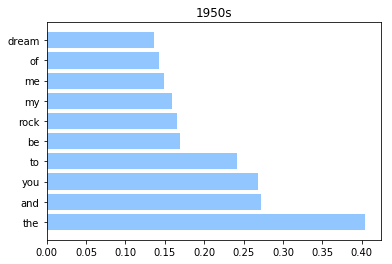

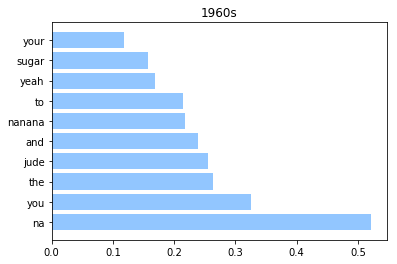

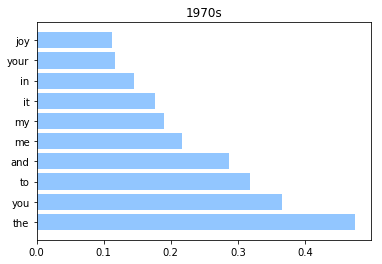

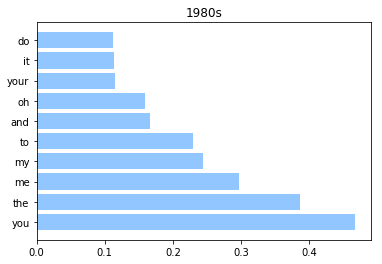

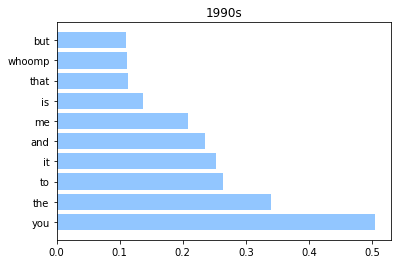

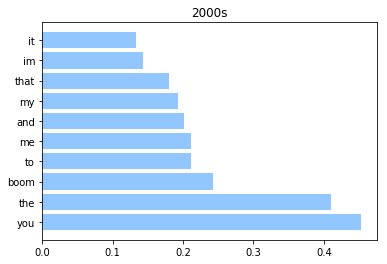

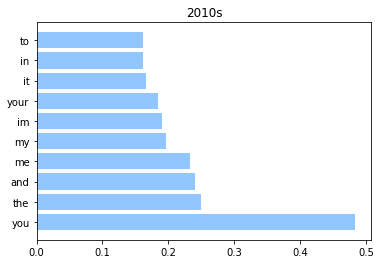

In [53]:
titles = music["Decade"]
i = 0

for decade in common:
    plt.barh(decade.index[:10], decade[:10])
    plt.title(titles[i])
    plt.show();
    #plt.savefig(titles[i]+"wordbar.png");
    i += 1

# Conclusion
Things I've Looked At:
* Unique Artists (Overall, Decade-wise)
* Number of Times An Artist Appeared
* Average Word Length
* Average Number of Words
* Parts of Speech
* Speculative Words
* Personal Pronouns
* Intimacy
* Egocentricity
* Gendered Pronouns
* Uniqueness
* Lyrics Through Time (Network Graph)
* Sentiment Analysis
* Word Frequencies
    * Love is consistently on the top 10 list.

It appears over time, words become shorter, but there are more words. That means songs have become snappier. I hypothesize the tempo of songs present-day is faster and perhaps there is a genre shift, but as I only have the song lyrics to work with, I cannot confirm my hypothesis.

There appears to be a shift from the songs focusing on "you," to convey intimacy, to "me," a more ego-centric point of view. Inclusive first person pronouns such as "we" and "us" are on the rise in the later years, implying a greater focus on the self and how the self relates to the outside world.
# What Next?
If I had more time, I would've definitely included more songs. As you can tell from the word clouds, because I didn't have enough datapoints, certain very repetitive phrases from certain songs ("Goodnight Irene", "Wooly Bully", "Uptown Funk") end up showing up very prominently in the data.
G)   5 points: What does it all mean? What did you find? What did you learn? What would you have done
differently if you had unlimited time and money? Where should future research go? (take-home points)